In [ ]:
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras

#RANDOM_SEED = 1

time_slot = 20

#resource requirement for each task r^k_m
r = np.array([[1, 2],
        [3, 4]])

Beta = np.array([0.5, 0.5]) #geometric distribution parameter

Lambda = np.array([0.3,0.3]) #iid Bernoulli process parameter







RANDOM_SEED = 42



timeslot_duration = 100
num_timeslot = 10000


K = 5;
M = 5; 
#action = np.array(np.zeros(M)) #action matrix for RL, 0 is don't process, 1 is process
#r = np.random.randint(3,5,(M,K))
r = np.zeros((M,K))
for i in range(M):
  for j in range(K):
    r[i,j] = i+1
C_k = np.random.randint(10,20,K)

Beta = np.full(M,0.1)

#U = np.random.randint(1,10,M)#reward per task
U = np.array([50,30,9])
print(r," resource required per task per type")
print(U," reward per task")
print(Beta," geometric processing time parameter")
print(C_k," global resources of type K")



[[1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2.]
 [3. 3. 3. 3. 3.]]  resource required per task per type
[50 30  9]  reward per task
[0.1 0.1 0.1]  geometric processing time parameter
[10 17 16 16 11]  global resources of type K


In [ ]:
RR_ratio = np.zeros((M,K))
for i in range(M):
  for j in range(K):
    RR_ratio[i,j] = U[i]/r[i,j]
print(RR_ratio)

[[50. 50. 50. 50. 50.]
 [15. 15. 15. 15. 15.]
 [ 3.  3.  3.  3.  3.]]


In [ ]:
!pip install simpy
import simpy

In [ ]:

class ReplayBuffer(object):
  def __init__(self,max_size,input_shape,input1,input2,n_actions):
    self.memsize = max_size
    self.mem_cntr = 0 
    self.state_memory = np.zeros((self.memsize,input1,input2))
    self.new_state_memory = np.zeros((self.memsize,input1,input2))
    self.action_memory = np.zeros((self.memsize), dtype= np.int8)
    self.reward_memory = np.zeros(self.memsize)


  def store_transistion(self,state,action,reward,newstate):
    index = self.mem_cntr % self.memsize
    self.state_memory[index] = state
    self.new_state_memory[index] = newstate
    self.action_memory[index] = action
    self.reward_memory[index] = reward
    self.mem_cntr += 1

  def sample_buffer(self,batch_size):
    max_mem = min(self.mem_cntr, self.memsize)
    batch = np.random.choice(max_mem,batch_size)

    states = self.state_memory[batch]
    new_states = self.new_state_memory[batch]
    actions = self.action_memory[batch]
    rewards = self.reward_memory[batch]
    return states,actions,rewards,new_states




In [ ]:
class Agent():
    def __init__(self, lr, gamma, n_actions, epsilon, batch_size, input_dims, input1,input2,mem_size=1000000,epsilon_dec=1e-3, epsilon_end=0.01, ):
        self.action_space = [i for i in range(2**M)]
        self.gamma = gamma
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.memory = ReplayBuffer(mem_size, input_dims,input1,input2,n_actions)
        self.q_eval = create_q_model(lr, n_actions, input1,input2, 64, 64)
        self.eps_dec = epsilon_dec
        self.eps_min = epsilon_end

    def store_transistion(self, state, action, reward, new_state):
        self.memory.store_transistion(state, action, reward, new_state)

    def choose_action(self, state,M):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
            #print("random action taken",action)
            #true = self.convert_RL_sim_action(action,M)

            return action
        else:
            #print(state,"is state for random action prediction")
            state = np.array([state])
            actions = self.q_eval.predict(state)

            action = np.argmax(actions)
            #print("action produced by Neural network")
            #t_action = self.convert_RL_sim_action(action)
            #true = self.convert_RL_sim_action(action,M)

            return action

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
          #dont learn because the replay buffer is not enough
          return

        states, actions, rewards, states_ = \
                self.memory.sample_buffer(self.batch_size)

        #output is bunch of actions
        #print(type(self.q_eval))
        q_eval = self.q_eval.predict(states) #calculate current state action
        q_next = self.q_eval.predict(states_) #calculate next state action


        q_target = np.copy(q_eval) #4 values with different weightings
        batch_index = np.arange(self.batch_size, dtype=np.int32)#
       # print(actions," is actions, ",actions.shape,"is actions shape",q_target.shape,"is q target shape")
        #update bellman's reward equation
        q_target[batch_index, actions] = rewards + \
                        self.gamma * np.max(q_next, axis=1)  #np.max determines the most likely action


        self.q_eval.train_on_batch(states, q_target)

        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > \
                self.eps_min else self.eps_min

    def save_model(self):
        self.q_eval.save(self.model_file)


    def load_model(self):
        self.q_eval = load_model(self.model_file)

   

    




In [ ]:
def convert_RL_sim_action(rl_action,M):

  """
  rl_action is the output of q_values from the neural network 
  returned is the action that can be interpreted by simpy
  """

  b_action = np.binary_repr(rl_action,width=M)
  #print("binary repr of action is:",b_action)
  L = list(b_action)
  #print("binary list of action is:",L)
  true_action = np.array(L, dtype=int)
  return true_action

def create_q_model(lr, n_actions, input1,input2, fc1_dims, fc2_dims):
    # Network defined by the Deepmind paper
  model = Sequential([
                Flatten(input_shape=(input1,input2)),
                Dense(fc1_dims),
                Activation('relu'),
                Dense(fc2_dims),
                Activation('relu'),
                Dense(n_actions)])

  model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
  return model
# The first model makes the predictions for Q-values which are used to
# make a action.
#model = create_q_model()
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
#model_target = create_q_model()

In [ ]:
#modified simpy example 

import random
import simpy
import scipy
import numpy as np
from scipy.stats import bernoulli


def state_gen(b,m,r,common_resource):
    gen = []
    C = []
    
    for i in range (K):
      tmp = common_resource[i].level#occupies the resource for processing
      C.append(tmp)
    for k in range(M):
      tmp = bernoulli.rvs(Beta[k])
      #tmp = 1#always tasks exists
      gen.append(tmp)
    new_gen = []
    for j in range (K):
      tmp = gen
      new_gen.append(gen)

    new_gen = np.array(new_gen)
    new_gen = np.transpose(new_gen)

    state = new_gen*r

    state = np.append(state, [C], axis=0)

    return state,gen



In [ ]:
class RL_env(object):
  #aim of this class is to simulate a complete timeslot DES
  def __init__(self,env,num_timeslot,timeslot_duration,common_resource,counter,RR_ratio):
    self.reward = 0 #reward per task
    self.rewards_per_slot = 0
    self.timeslot_duration = timeslot_duration
    self.common_resource = common_resource
    #self.env = simpy.Environment()
    self.env = env
    self.counter = counter
    #self.counter = simpy.Resource(env, capacity=2*M)
    self.num_timeslot = num_timeslot
    self.timeslot_duration = timeslot_duration
    self.agent_reward_per_slot = np.zeros(K)
    self.RR_ratio = RR_ratio

  def interact_with_agent_1(self, env, agent, state):

    agent_action = agent.choose_action(state,M) 
    
    return agent_action


  def slot(self, counter, gen, agent1, agent2, agent3, agent4, agent5, score, state, reward_sum, reward_sum_history,agent_reward_history):
    """timeslot,generate the arrival of M different tasks, for one episode"""

    for i in range(self.num_timeslot):
      self.rewards_per_slot = 0
      self.reward = 0
      self.agent_reward_per_slot = np.zeros(K)

      action1 = self.interact_with_agent_1(env,agent1,state)
      state1 = inter_agent_transistion(state,action1)

      action2 = self.interact_with_agent_1(env,agent2,state1)
      state2 = inter_agent_transistion(state1,action2)

      action3 = self.interact_with_agent_1(env,agent3,state2)
      state3 = inter_agent_transistion(state2,action3)

      action4 = self.interact_with_agent_1(env,agent4,state3)
      state4 = inter_agent_transistion(state3,action4)

      action5 = self.interact_with_agent_1(env,agent5,state4)
      state5 = inter_agent_transistion(state4,action5)


      true_action = convert_RL_sim_action(action5,M)

      for j in range(M):
        
        if gen[j]:  
          #print("generate tasks")
          self.env.process(  self.task_arrival(env, 'timelsot No. %02d, task %01d' % (i,j), self.counter,  true_action, j) )
          
        else:
          pass
      yield self.env.timeout(self.timeslot_duration)
      reward_sum += self.rewards_per_slot

      #need to fix agent_reward_per_slot!!!!
      agent_r = self.agent_reward_per_slot
      agent_reward_history.append(agent_r)
      reward = self.rewards_per_slot
      #print("a_r_perslot is:",agent_r)

      score.append(reward)
      new_state,gen = state_gen(Beta,M,r,common)

      #do some prediction that can be used by next agent
      agent1.store_transistion(state,action1,agent_r[0],new_state)
      action1 = self.interact_with_agent_1(env,agent1,new_state)
      new_state1 = inter_agent_transistion(new_state,action1)

      agent2.store_transistion(state1,action2,agent_r[1],new_state1)
      action2 = self.interact_with_agent_1(env,agent2,new_state1)
      new_state2 = inter_agent_transistion(new_state1,action2)


      agent3.store_transistion(state2,action3,agent_r[2],new_state2)
      action3 = self.interact_with_agent_1(env,agent3,new_state2)
      new_state3 = inter_agent_transistion(new_state2,action3)

      agent4.store_transistion(state3,action4,agent_r[3],new_state3)
      action4 = self.interact_with_agent_1(env,agent1,new_state3)
      new_state4 = inter_agent_transistion(new_state3,action4)

      agent5.store_transistion(state4,action5,agent_r[4],new_state4)



      state = new_state
      agent1.learn()
      agent2.learn()
      agent3.learn()
      agent4.learn()
      agent5.learn()


      #new_state,gen = self.interact_with_agent_2( env, agent,score, state,agent_action)
      #state = new_state

    reward_sum_history.append(reward_sum)

    #print("rewards is :",self.rewards_per_slot,"reward ",self.reward)
    
    #yield self.env.timeout(interval) 
  
  def task_arrival(self, env, name, counter,  action, m):
    """
    For a single task M, figure out whether to process it or not
    with action vector
    also need to return status of whether the task was sucessful or not
    """
    arrive = self.env.now
    #print('%7.4f %s: Task arrives' % (arrive, name))

    with counter.request() as req:  #performing certain a single task m

        #use action vector to check if this task
        allocate = True
        if action[m] == 0 :
          allocate = False
          #print('%7.4f %s: Action is not to process' % (env.now, name))

        if allocate:
          check = True
        
          #make use of action vector so that uncessary checks are obmitted
          for i in range(0,K):
            if self.common_resource[i].level < r[m,i]:
              #print('%7.4f %s: %1d %1d resource not satisfied for type: %1d'% (env.now,name, common_resource[i].level , r[i,1],i))
              print('%7.4f %s: resource not satisified, need resource %d, have resource %d' % (env.now, name,r[i,1],common_resource[i].level))
              check = False
              self.reward = 0

        
          """Starts processing if resource requiremenet is satisfied"""
          if check == True:
            
            for i in range (0,K):
              self.common_resource[i].get(r[m,i])#occupies the resource for processing
            #determines the length of processing
            tib = np.random.geometric(Beta[m])
            #t = 11
            yield env.timeout(tib)
            #print('%7.4f %s: Finished Processing' % (env.now, name))
            self.reward = U[m] #sucessfully allocated
            self.rewards_per_slot += self.reward
            #print("reward is:",self.reward)
            for i in range (0,K):
              self.agent_reward_per_slot[i] += self.RR_ratio[m,i]
              yield self.common_resource[i].put(r[m,i])#release the resources
            #time_left
            #print('%7.4f %s: Task resource released' % (env.now, name))
            
          

          else:
            #the resource does not satisfy, don't do this task.
            self.reward = 0 #sucessfully allocated
            yield env.timeout(0)

            #print('%7.4f %s: allocation failed' % (env.now, name))
    

  
  def interact_with_agent_2(self, env, agent,score,state,agent_action):
    #state = 0
    eps_history.append(agent.epsilon)
    #env.run() executed in the main program

    reward = rl_env.rewards_per_slot
    
    #print(reward," is reward for timeslot")
    
    #print("One timesloot is finished, can produce state, action, reward",env.now)
    """Calculate state,action,reward. need to call state_gen for the new states."""
    new_state,gen = state_gen(Beta,M,r,common)
    #score += reward
    #print("step",i)
    score.append(reward)
    agent.store_transistion(state,agent_action,reward,new_state)
    
    agent.learn()
    state = new_state
    
    return state,gen


In [ ]:
def inter_agent_transistion(state,action):
  """
  Change the state info based on the action provided 
  (e.g. The first agent only allow first two tasks to be processed, 
  the corresponding state would only have resource for the first two tasks, 
  all other tasks' resource requirement will be set to zero)
  """
  env_action = convert_RL_sim_action(action,M) #convert to binary array actions
  for i in range(M):
    if env_action[i] == 0:
      #drop the task
      for j in range(K):
        state[i,j] = 0
  return state

  

##Execution Program:

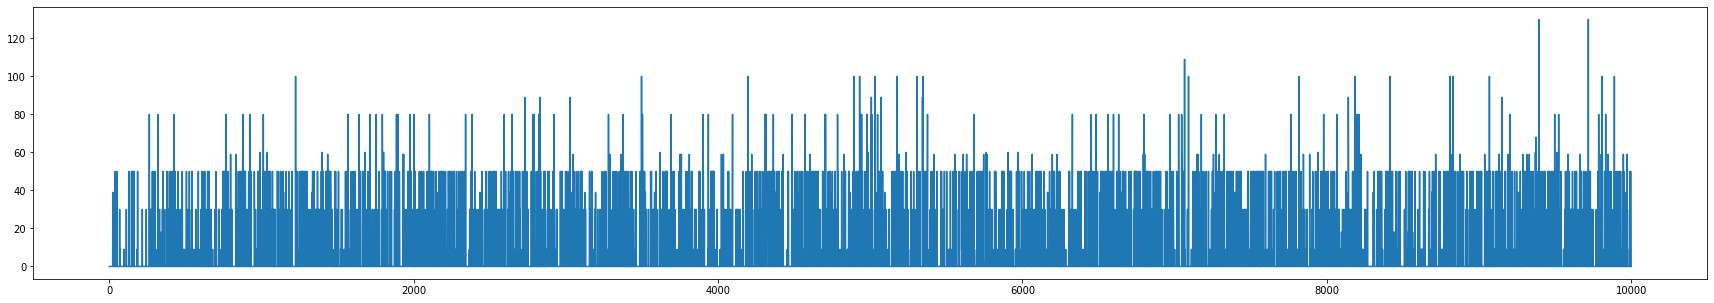

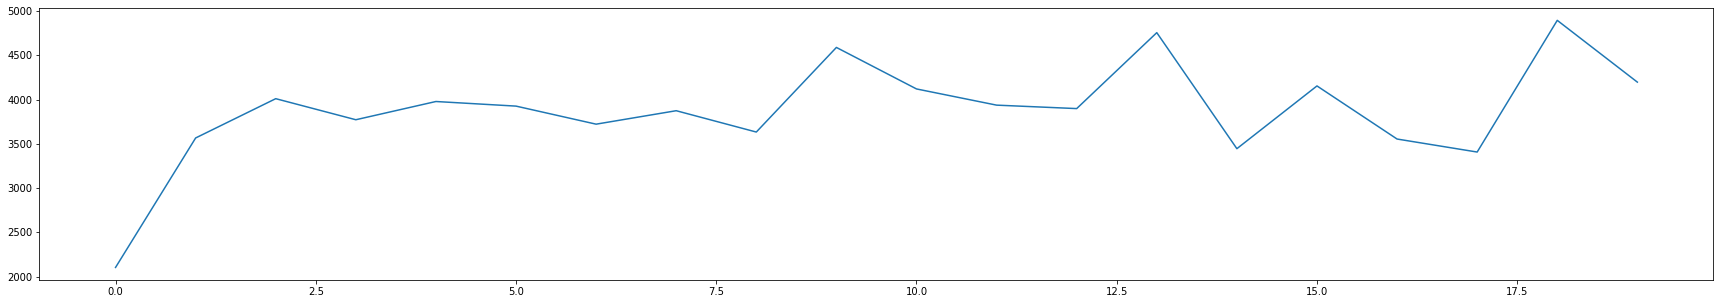

In [ ]:
#test program
import matplotlib
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Activation,Flatten 
from keras.models import Sequential, load_model
from keras.optimizers import Adam




random.seed(RANDOM_SEED)

env = simpy.Environment()
timeslot_duration = 10

num_timeslot = 500
num_timeslot_per_episode = 500
episode = 20


#establishing common resources C_k
common = []
for i in range(0,len(C_k)):
  tmp = simpy.Container(env, C_k[i], init=C_k[i])
  common.append(tmp)


  # Start processes and run
counter = simpy.Resource(env, capacity=3*M) #for processing M different tasks
state,gen = state_gen(Beta,M,r,common)

#initializing environment
agent1 = Agent(lr= 0.001,gamma = 0.9, n_actions = 2**M, epsilon = 0.9,epsilon_dec=1e-3, epsilon_end=0.01, batch_size=64,
                input_dims = (M+1)*K, input1=M+1,input2=K, mem_size=500)
agent2 = Agent(lr= 0.001,gamma = 0.9, n_actions = 2**M, epsilon = 0.9,epsilon_dec=1e-3, epsilon_end=0.01, batch_size=64,
                input_dims = (M+1)*K, input1=M+1,input2=K, mem_size=500)
agent3 = Agent(lr= 0.001,gamma = 0.9, n_actions = 2**M, epsilon = 0.9,epsilon_dec=1e-3, epsilon_end=0.01, batch_size=64,
                input_dims = (M+1)*K, input1=M+1,input2=K, mem_size=500)
agent4 = Agent(lr= 0.001,gamma = 0.9, n_actions = 2**M, epsilon = 0.9,epsilon_dec=1e-3, epsilon_end=0.01, batch_size=64,
                input_dims = (M+1)*K, input1=M+1,input2=K, mem_size=500)
agent5 = Agent(lr= 0.001,gamma = 0.9, n_actions = 2**M, epsilon = 0.9,epsilon_dec=1e-3, epsilon_end=0.01, batch_size=64,
                input_dims = (M+1)*K, input1=M+1,input2=K, mem_size=500)  
  
eps_history = []
rl_env = RL_env(env,num_timeslot,timeslot_duration,common,counter,RR_ratio)
  
score = []
average_reward_per_episode = 0
reward_sum_history=[]
agent_reward = 0
a_r_history = []

for j in range(episode):

  reward_sum = 0

  env.process(rl_env.slot(counter,gen,agent1,agent2,agent3,agent4,agent5,score,state,reward_sum,reward_sum_history,a_r_history))

  


  env.run()

  
plt.figure(figsize=(30,5))
plt.plot(score)
plt.figure(figsize=(30,5))
plt.plot(reward_sum_history)

#problem!!! with this characteristic, the training and interaction with DQN need to implemented within the slot.

TypeError: ignored

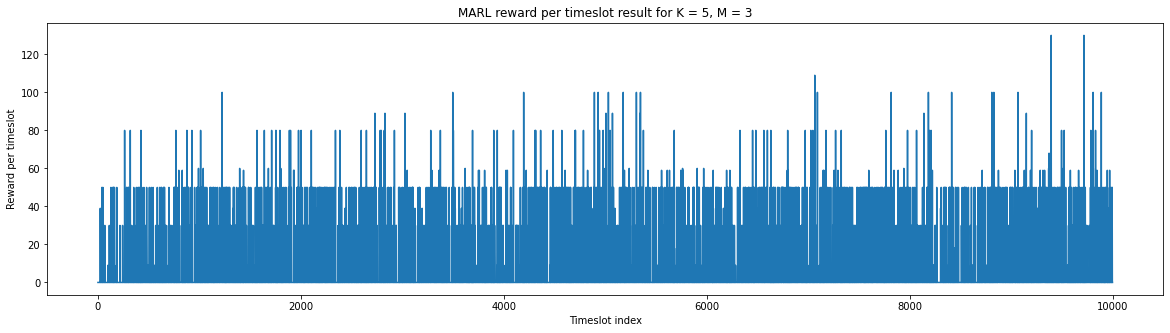

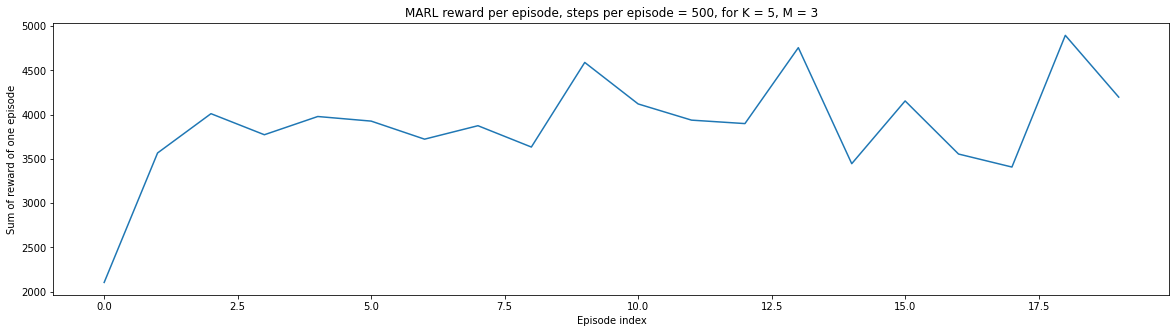

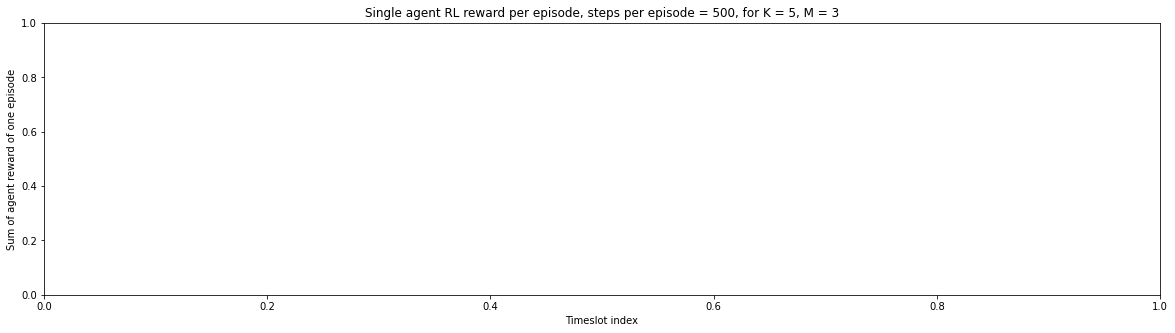

In [ ]:
plt.figure(figsize=(20,5))
plt.xlabel('Timeslot index')
plt.ylabel('Reward per timeslot')
plt.title('MARL reward per timeslot result for K = 5, M = 3')
plt.plot(score)
plt.figure(figsize=(20,5))
plt.xlabel('Episode index')
plt.ylabel('Sum of reward of one episode')
plt.title('MARL reward per episode, steps per episode = 500, for K = 5, M = 3')
plt.plot(reward_sum_history)

plt.figure(figsize=(20,5))
plt.xlabel('Timeslot index')
plt.ylabel('Sum of agent reward of one episode')
plt.title('Single agent RL reward per episode, steps per episode = 500, for K = 5, M = 3')
plt.plot(a_r_history[1,:])

In [ ]:
print(a_r_history)

10000


In [ ]:
# Setup and start the simulation

#main program
import matplotlib
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
  
from keras.layers import Dense, Activation,Flatten 
from keras.models import Sequential, load_model
from keras.optimizers import Adam


num_timeslot = 5000
episode = 50

  
print('Simulation starts, number of timeslot = %d, timeslot duration = %d, M = %d K = %d'%(num_timeslot,timeslot_duration,M,K))
random.seed(RANDOM_SEED)
env = simpy.Environment()
#establishing common resources C_k
common = []
for i in range(0,len(C_k)):
  tmp = simpy.Container(env, C_k[i], init=C_k[i])
  common.append(tmp)


  # Start processes and run
counter = simpy.Resource(env, capacity=2*M) #for processing M different tasks
state,gen = state_gen(Beta,M,r,common)


agent1 = Agent(lr= 0.001,gamma = 0.9, n_actions = 2**M, epsilon = 0.9,epsilon_dec=1e-3, epsilon_end=0.01, batch_size=64,
                input_dims = (M+1)*K, input1=M+1,input2=K, mem_size=500)
agent2 = Agent(lr= 0.001,gamma = 0.9, n_actions = 2**M, epsilon = 0.9,epsilon_dec=1e-3, epsilon_end=0.01, batch_size=64,
                input_dims = (M+1)*K, input1=M+1,input2=K, mem_size=500)
agent3 = Agent(lr= 0.001,gamma = 0.9, n_actions = 2**M, epsilon = 0.9,epsilon_dec=1e-3, epsilon_end=0.01, batch_size=64,
                input_dims = (M+1)*K, input1=M+1,input2=K, mem_size=500)
agent4 = Agent(lr= 0.001,gamma = 0.9, n_actions = 2**M, epsilon = 0.9,epsilon_dec=1e-3, epsilon_end=0.01, batch_size=64,
                input_dims = (M+1)*K, input1=M+1,input2=K, mem_size=500)
agent5 = Agent(lr= 0.001,gamma = 0.9, n_actions = 2**M, epsilon = 0.9,epsilon_dec=1e-3, epsilon_end=0.01, batch_size=64,
                input_dims = (M+1)*K, input1=M+1,input2=K, mem_size=500)  

agent_reward = 0

eps_history = []
rl_env = RL_env(env,num_timeslot,timeslot_duration,common,counter)
  
score = []
average_reward_per_episode = 0
for i in range(num_timeslot):
  
  
  action1 = agent1.choose_action(state,M) 
  #true_action1 = convert_RL_sim_action(action1,M)
  state1 = inter_agent_transistion(state,action1)

  action2 = agent2.choose_action(state1,M)
  state2 = inter_agent_transistion(state1,action2)

  action3 = agent3.choose_action(state2,M)
  state3 = inter_agent_transistion(state2,action3)

  action4 = agent4.choose_action(state3,M)
  state4 = inter_agent_transistion(state3,action4)

  action5 = agent5.choose_action(state4,M)
  state5 = inter_agent_transistion(state4,action5)

  true_action = convert_RL_sim_action(action5,M)
  #before process, let all agent do state transistion
  env.process(rl_env.slot(env,num_timeslot,timeslot_duration,counter,gen,true_action,common,i))

  
  #eps_history.append(agent.epsilon)
  env.run()
  

  agent_r = rl_env.agent_reward_per_slot
  reward = rl_env.rewards_per_slot
  print("a_r_perslot is:",agent_r,i)
  #print(reward," is reward for timeslot:",i)
    
  #print("One timesloot is finished, can produce state, action, reward",env.now)
  """Calculate state,action,reward. need to call state_gen for the new states."""
  new_state,gen = state_gen(Beta,M,r,common)

  score.append(reward)

  """questionable of stroing transistion with the new state value??"""
  agent1.store_transistion(state,action1,agent_r[0],new_state)
  agent2.store_transistion(state1,action2,agent_r[1],new_state)
  agent3.store_transistion(state2,action3,agent_r[2],new_state)
  agent4.store_transistion(state3,action4,agent_r[3],new_state)
  agent5.store_transistion(state4,action5,agent_r[4],new_state)


  state = new_state
  agent1.learn()
  agent2.learn()
  agent3.learn()
  agent4.learn()
  agent5.learn()


plt.plot(score)
#plt.plot(eps_history)

Simulation starts, number of timeslot = 5000, timeslot duration = 100, M = 5 K = 5
a_r_perslot is: [60. 60. 60. 60. 60.]
a_r_perslot is: [60. 60. 60. 60. 60.]
a_r_perslot is: [30. 30. 30. 30. 30.]
a_r_perslot is: [60. 60. 60. 60. 60.]
a_r_perslot is: [15. 15. 15. 15. 15.]
a_r_perslot is: [55. 55. 55. 55. 55.]
a_r_perslot is: [55. 55. 55. 55. 55.]
a_r_perslot is: [70. 70. 70. 70. 70.]
a_r_perslot is: [5. 5. 5. 5. 5.]
a_r_perslot is: [0. 0. 0. 0. 0.]
a_r_perslot is: [50. 50. 50. 50. 50.]
a_r_perslot is: [25. 25. 25. 25. 25.]
a_r_perslot is: [55. 55. 55. 55. 55.]
a_r_perslot is: [25. 25. 25. 25. 25.]
a_r_perslot is: [0. 0. 0. 0. 0.]
a_r_perslot is: [70. 70. 70. 70. 70.]
a_r_perslot is: [60. 60. 60. 60. 60.]
a_r_perslot is: [70. 70. 70. 70. 70.]
a_r_perslot is: [70. 70. 70. 70. 70.]
a_r_perslot is: [25. 25. 25. 25. 25.]
a_r_perslot is: [70. 70. 70. 70. 70.]
a_r_perslot is: [60. 60. 60. 60. 60.]
a_r_perslot is: [60. 60. 60. 60. 60.]
a_r_perslot is: [60. 60. 60. 60. 60.]
a_r_perslot is: [70.

KeyboardInterrupt: ignored

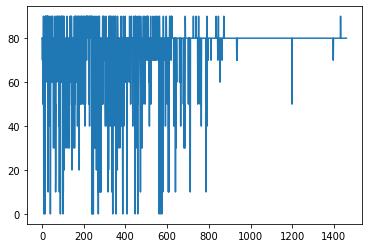

In [ ]:
plt.plot(score)

In [ ]:
# Setup and start the simulation

#main program
import matplotlib
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
  
from keras.layers import Dense, Activation,Flatten 
from keras.models import Sequential, load_model
from keras.optimizers import Adam

print('Simulation starts, number of timeslot = %d, timeslot duration = %d, M = %d K = %d'%(num_timeslot,timeslot_duration,M,K))
random.seed(RANDOM_SEED)
env = simpy.Environment()
#establishing common resources C_k
common = []
for i in range(0,len(C_k)):
  tmp = simpy.Container(env, C_k[i], init=C_k[i])
  common.append(tmp)


  # Start processes and run
counter = simpy.Resource(env, capacity=2*M) #for processing M different tasks
state,gen = state_gen(Beta,M,r,common)
#agent = Agent(lr= 0.001,gamma = 0.9, n_actions = 2**M, epsilon = 0.9,epsilon_dec=1e-3, epsilon_end=0.01, batch_size=64,
                #input_dims = (M+1)*K, input1=M+1,input2=K, mem_size=500)
agent1 = Agent(lr= 0.001,gamma = 0.9, n_actions = 2**M, epsilon = 0.9,epsilon_dec=1e-3, epsilon_end=0.01, batch_size=64,
                input_dims = (M+1)*K, input1=M+1,input2=K, mem_size=500)
agent2 = Agent(lr= 0.001,gamma = 0.9, n_actions = 2**M, epsilon = 0.9,epsilon_dec=1e-3, epsilon_end=0.01, batch_size=64,
                input_dims = (M+1)*K, input1=M+1,input2=K, mem_size=500)
agent3 = Agent(lr= 0.001,gamma = 0.9, n_actions = 2**M, epsilon = 0.9,epsilon_dec=1e-3, epsilon_end=0.01, batch_size=64,
                input_dims = (M+1)*K, input1=M+1,input2=K, mem_size=500)
agent4 = Agent(lr= 0.001,gamma = 0.9, n_actions = 2**M, epsilon = 0.9,epsilon_dec=1e-3, epsilon_end=0.01, batch_size=64,
                input_dims = (M+1)*K, input1=M+1,input2=K, mem_size=500)
agent5 = Agent(lr= 0.001,gamma = 0.9, n_actions = 2**M, epsilon = 0.9,epsilon_dec=1e-3, epsilon_end=0.01, batch_size=64,
                input_dims = (M+1)*K, input1=M+1,input2=K, mem_size=500)  

eps_history = []
rl_env = RL_env(env,num_timeslot,timeslot_duration,common,counter)
  
score = []
average_reward_per_episode = 0

num_timeslot = 5000
num_timeslot_per_episode = 500
episode = 10
reward_sum = 0
reward_sum_per_episode=[]
sum_reward = 0

Simulation starts, number of timeslot = 5000, timeslot duration = 100, M = 5 K = 5


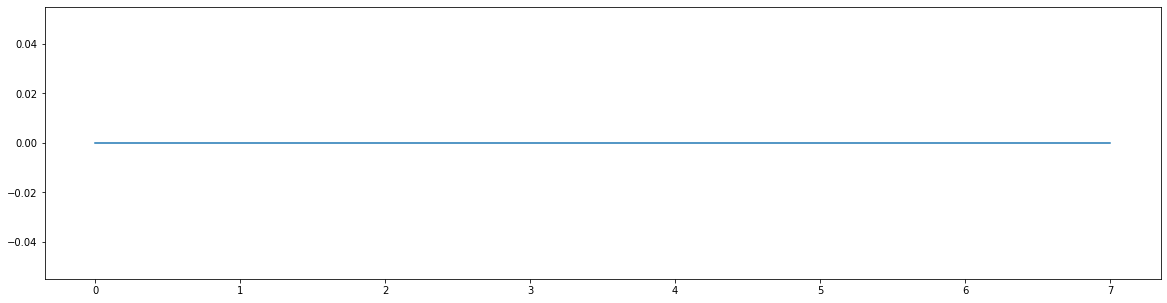

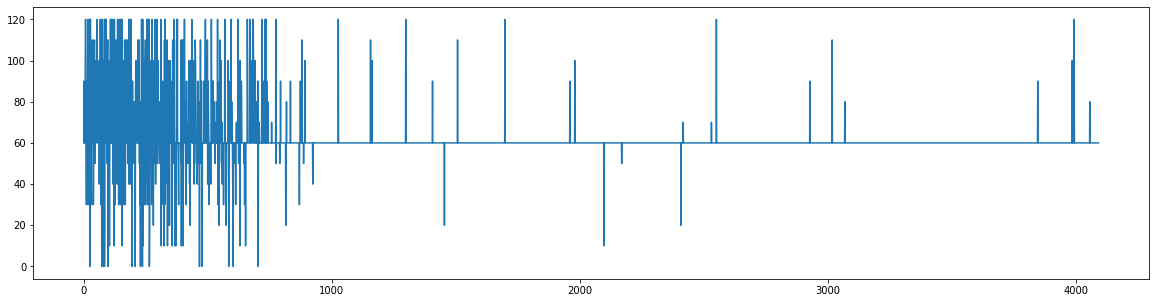

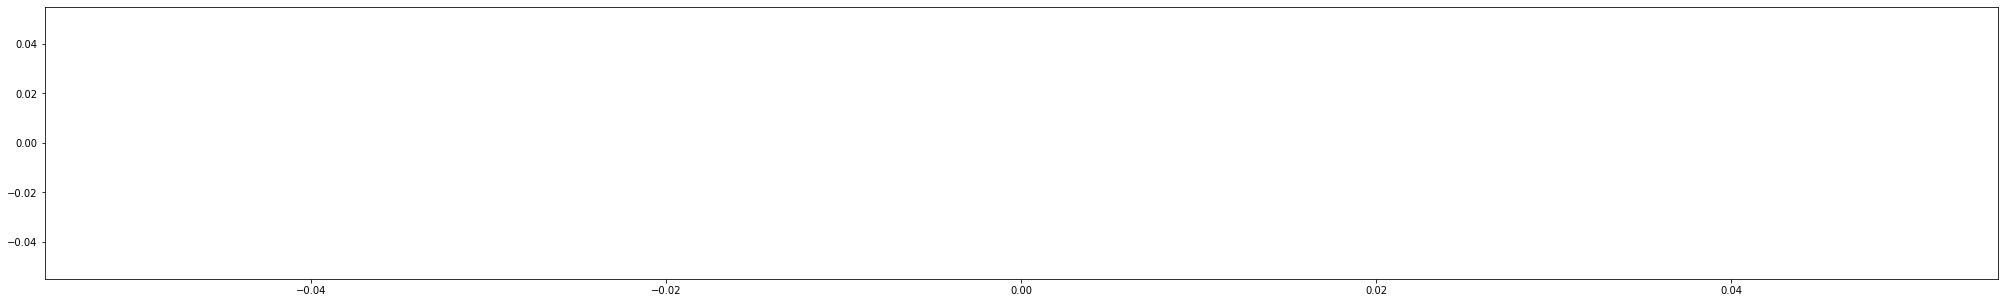

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(reward_sum_per_episode)
plt.figure(figsize=(20,5))
plt.plot(score)
plt.figure(figsize=(35,5))
plt.plot(reward_sum)

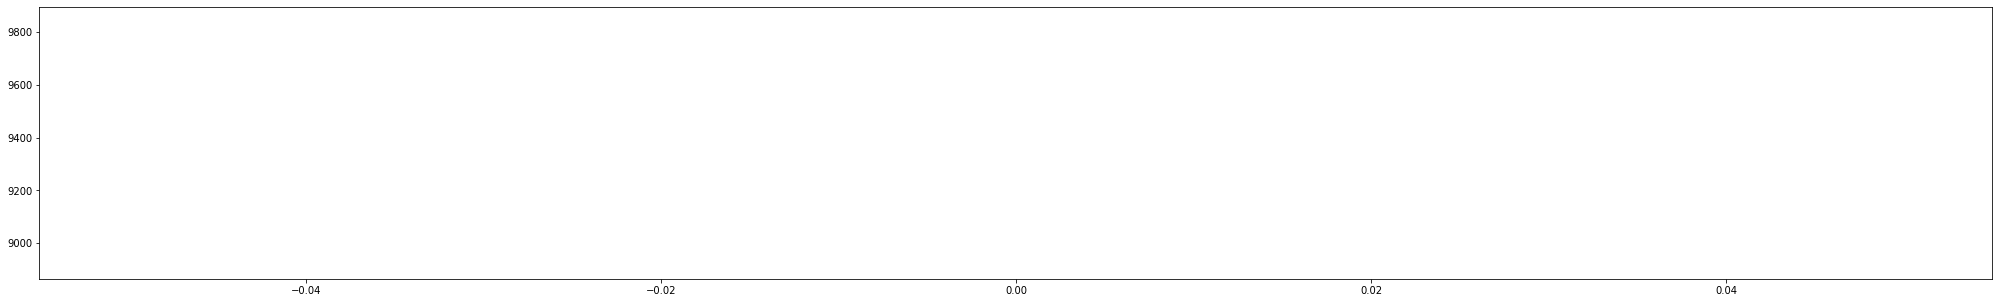

In [ ]:
plt.figure(figsize=(35,5))
plt.plot(reward_sum)

Cases when it starts to work:

[[1 2 1]

 [1 1 1]

 [2 1 2]

 [2 2 2]
 
 [2 1 1]]  
resource required per task per type

[4 1 9 9 6]  
reward per task

[0.1 0.1 0.1 0.1 0.1]  
geometric processing time parameter

[14 14 10]  global resources of type K

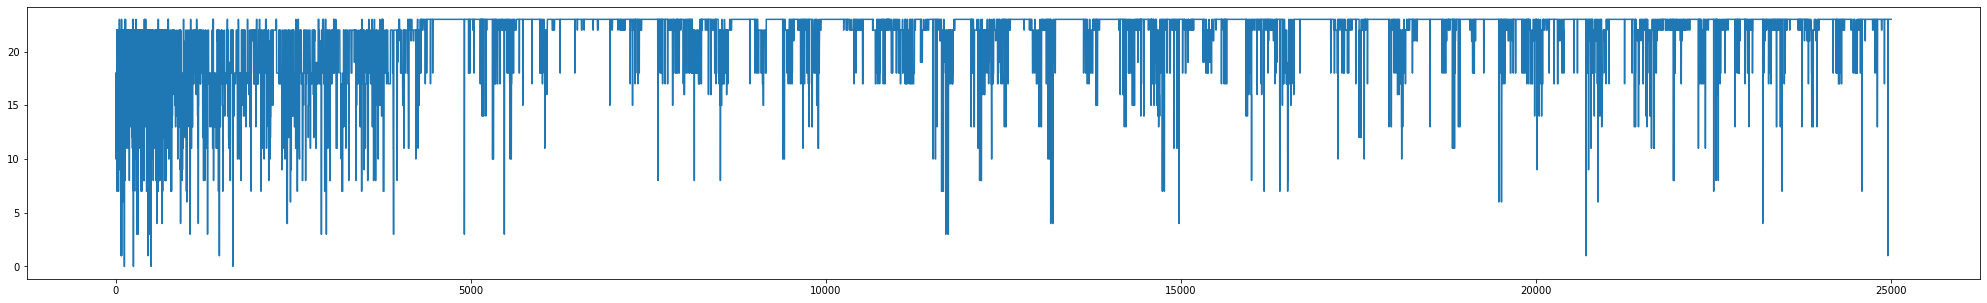

In [ ]:
plt.figure(figsize=(35,5))
plt.plot(score)